### This notebook loads a dataframe of stars from DES DR3 / DELVE DR3 in the spatial vicinity of the AAU Stream. It plots a matched-filter map based on a synthetic isochrone fit to AAU's age and metallicity, and overlays high-likelihood member stars from a DELVE x Gaia crossmatch that includes proper motions.

In [1]:
import numpy as np
import pandas as pd
import healpy as hp
import dask
import hats
import lsdb
import astropy
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy import units as u
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
from ugali.analysis.isochrone import factory as isochrone_factory
import os
import logging
import time
import sys
code_path = "/astro/users/esb30/software/spreading_seas/code"
sys.path.append(code_path)
plt.rcParams['font.family'] = 'serif'
from aau_fit_functions import spatial_fit_function

In [2]:
'''dxg_aau.parquet is a large file available at https://drive.google.com/file/d/1cx4ZL2fS2F7M9kmKux5P29YFMgqQj0KY/view?usp=drive_link'''
dxg_aau = pd.read_parquet('/astro/users/esb30/software/spreading_seas/notebooks/dxg_aau.parquet')

In [3]:
print(f'Spatial Box Columns:\n{dxg_aau.columns}')

Spatial Box Columns:
Index(['coadd_object_id', 'ra', 'dec', 'phi1', 'phi2', 'g_mag', 'r_mag',
       'i_mag', 'z_mag', 'gaia_g', 'gaia_bp', 'gaia_rp', 'gaia', 'pmra',
       'pmdec', 'pmra_error', 'pmdec_error', 'pmphi1', 'pmphi2', 'p_pmra',
       'p_pmdec', 'p_spatial', 'p_photometric', 'p_total', 'is_s5_member',
       'photometric_score', 'is_background'],
      dtype='object')


In [4]:
dxg_aau_members = dxg_aau[dxg_aau['p_total'] > 0.7]
dxg_aau_matched = dxg_aau[dxg_aau['p_photometric'] == 1]

(-6.0, 6.0)

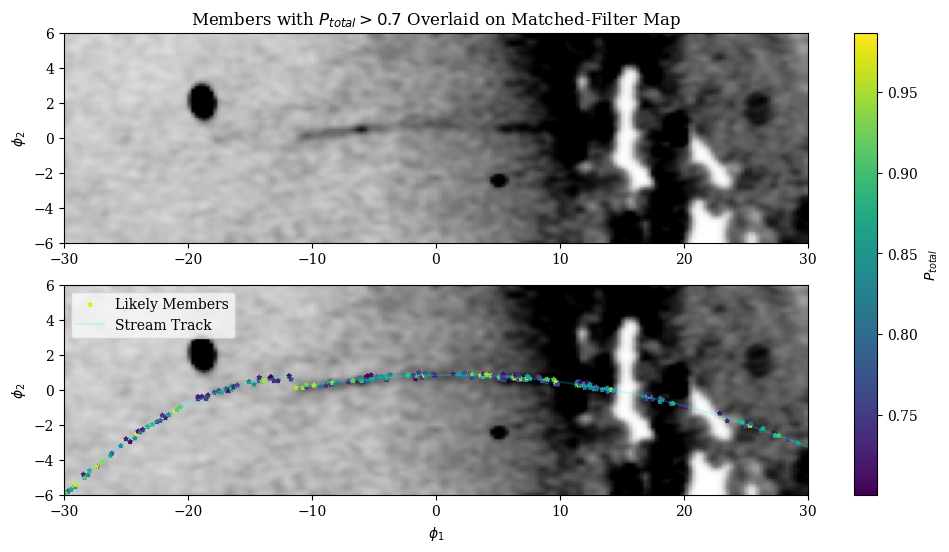

In [6]:
fig, [ax,ax1] = plt.subplots(2,1,figsize=[12,6])
bins_x = np.linspace(-30, 30, 200)
bins_y = np.linspace(-6, 6, 80)
H1, xedges1, yedges1 = np.histogram2d(dxg_aau_matched['phi1'], dxg_aau_matched['phi2'], bins=[bins_x, bins_y])
smoothed_H1 = gaussian_filter(H1.T, sigma=1)
hist= ax.imshow(
    smoothed_H1,
    extent=[bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]],
    origin='lower',
    cmap='Grays',
    aspect='auto',
#    vmin=0,
    vmax=40,
)
hist1= ax1.imshow(
    smoothed_H1,
    extent=[bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]],
    origin='lower',
    cmap='Grays',
    aspect='auto',
#    vmin=0,
    vmax=40,
)
im = ax1.scatter(dxg_aau_members['phi1'], dxg_aau_members['phi2'], c=dxg_aau_members['p_total'], s=10, cmap='viridis', label='Likely Members', marker='*')
ax1.plot(bins_x,spatial_fit_function(bins_x), label='Stream Track', alpha=0.2, c='aqua')
cbar = fig.colorbar(im, ax=[ax, ax1], orientation='vertical', label=r'$P_{total}$')
ax1.legend(loc='upper left', framealpha=0.7)
ax.set_xlim(-30,30)
ax.set_ylim(-6,6)
ax.set_title(r'Members with $P_{total} > 0.7$ Overlaid on Matched-Filter Map')
ax.set_ylabel(r'$\phi_2$')
ax1.set_ylabel(r'$\phi_2$')
ax1.set_xlabel(r'$\phi_1$')
ax1.set_ylim(-6,6)